In [24]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
torch.manual_seed(2024)
import torch.nn as nn

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 30, 'font.family': 'Helvetica', 'text.usetex': False})
%matplotlib inline

from utils.models import MLP
from utils.trainer import train_MLP
from utils.data import create_xor_dataset
from utils.plotting import plot_var, plot_task_rep, plot_hidden_in, plot_hidden_out
from utils.constants import COLORS

import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


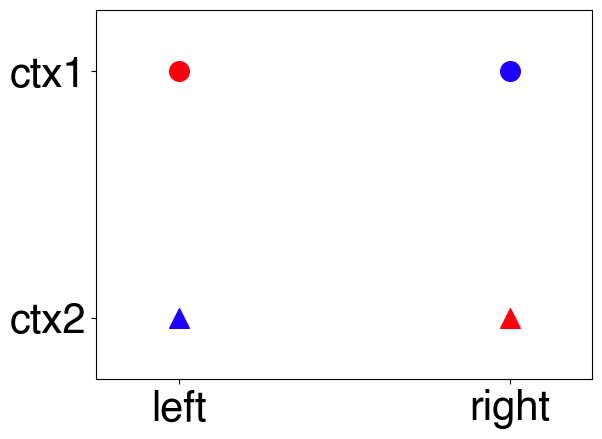

In [26]:
x1 = np.array ([-1., -1., 1., 1.], dtype = np.float32)
x2 = np.array ([-1., 1., -1., 1.], dtype = np.float32)
y_np  = np.array ([-1., 1., 1., -1.],dtype = np.float32)

X, y = create_xor_dataset(x1, x2, y_np, n_repeats=1, noise_lev=0)

fig, ax = plot_task_rep(X, y)

In [4]:
n_runs = 20
n_epochs = 5000  # Number of epochs
dim_input = 2  # Input dimension = (X, Y)
dim_hidden = 500  # Hidden neurons
dim_output = 1  # Output dimension = Category A or B (1, -1)

lr = 2e-3  # Learning rate
# Initialization scale
w1_inits = [0.0025, 0.25]
# w1_inits = [0.001,0.01,0.1,0.5]
w2_init = 1/dim_hidden

init_models = []
trained_models = []
losses = np.zeros((len(w1_inits), n_runs, n_epochs))
w1_rel_changes = np.zeros((len(w1_inits), n_runs, n_epochs))
w2_rel_changes = np.zeros((len(w1_inits), n_runs, n_epochs))

# Training
for w_i, w1_init in enumerate(w1_inits):
    for r_i in range(n_runs):
        # Model instantiation
        dlnn_model = MLP(dim_input, dim_hidden, dim_output, w1_init, w2_init)
        if r_i + 1 == n_runs:
            init_models.append(copy.deepcopy(dlnn_model))
    
        loss_per_run, weight_rel_changes_per_run = train_MLP(dlnn_model, X, y, n_epochs=n_epochs, lr=lr)
        losses[w_i, r_i, :] = loss_per_run
        w1_rel_changes[w_i, r_i, :] = weight_rel_changes_per_run[0]
        w2_rel_changes[w_i, r_i, :] = weight_rel_changes_per_run[1]

    trained_models.append(dlnn_model)

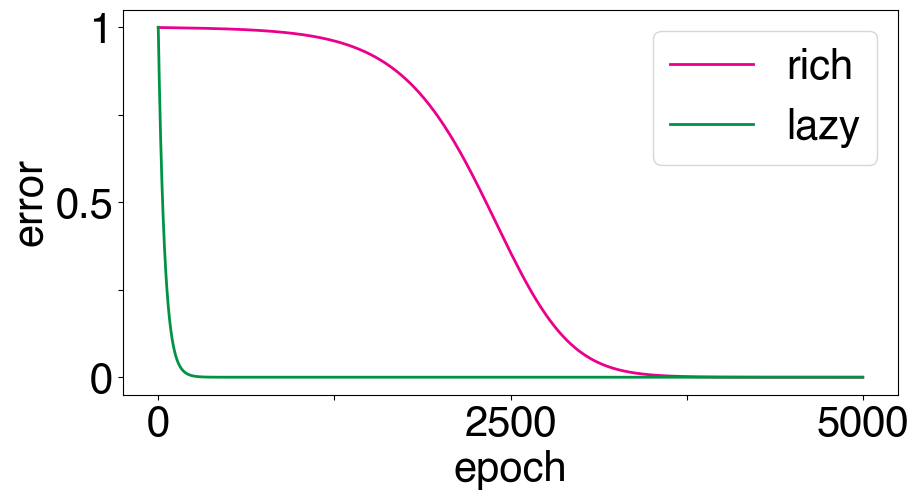

In [34]:
fig, _ = plot_var(losses, y_tick_labels=[0, None, 0.5, None, 1], y_ticks=[0, 0.25, 0.5, 0.75, 1])
fig.savefig("rich_lazy_training_loss.svg")

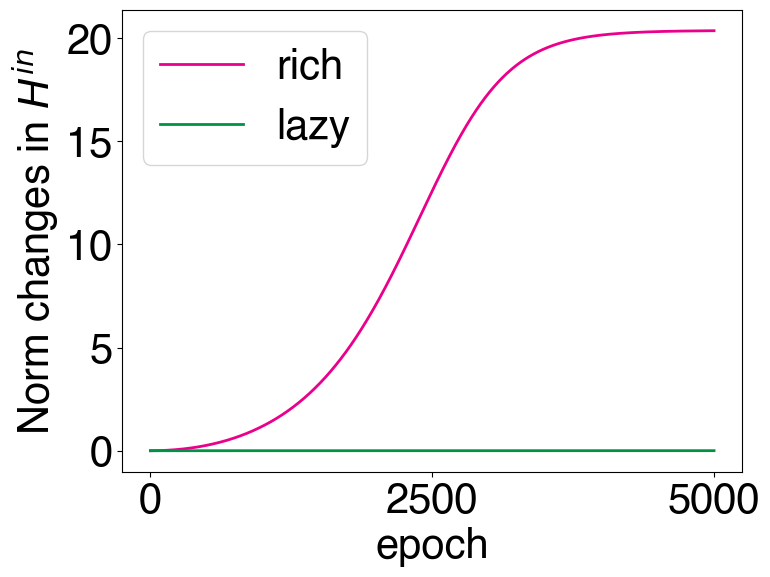

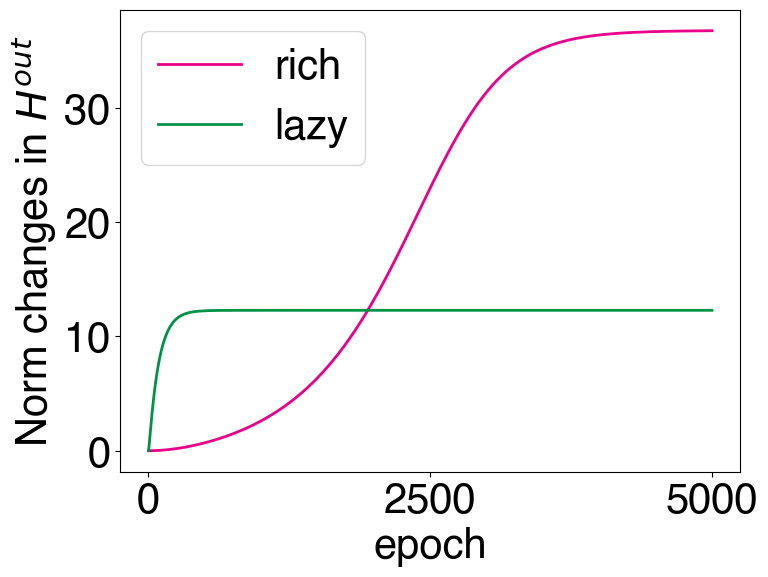

In [28]:
# Plotting relative changes of norms in wieghts
fig = plot_var(w1_rel_changes, y_label="Norm changes in $H^{in}$", fig_size=(8, 6))
# plt.savefig("input_norm_changes.svg")

fig = plot_var(w2_rel_changes, y_label="Norm changes in $H^{out}$", fig_size=(8, 6))
# plt.savefig("output_norm_changes.svg")

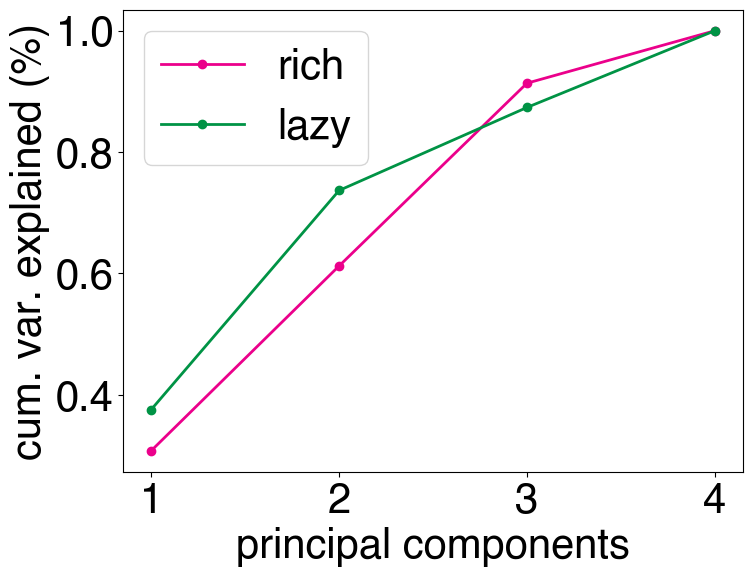

In [29]:
model_titles = ['rich', 'lazy']

fig, axis = plt.subplots()
fig.set_size_inches(8, 6)
for m_i, model in enumerate(trained_models):
    _, hiddens = model(X)
    hidden_act = hiddens.detach().numpy().T
    
    scaler = StandardScaler()
    hidden_act = scaler.fit_transform(hidden_act)
    pca = PCA()
    pca.fit(hidden_act)

    PC_values = np.arange(pca.n_components_) + 1
    axis.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), 'o-',
              linewidth=2, color=COLORS[model_titles[m_i]], label=model_titles[m_i])
axis.set_xlabel('principal components')
axis.set_ylabel('cum. var. explained (%)')
axis.legend()

# fig.savefig("rich_lazy_var_explained.svg")

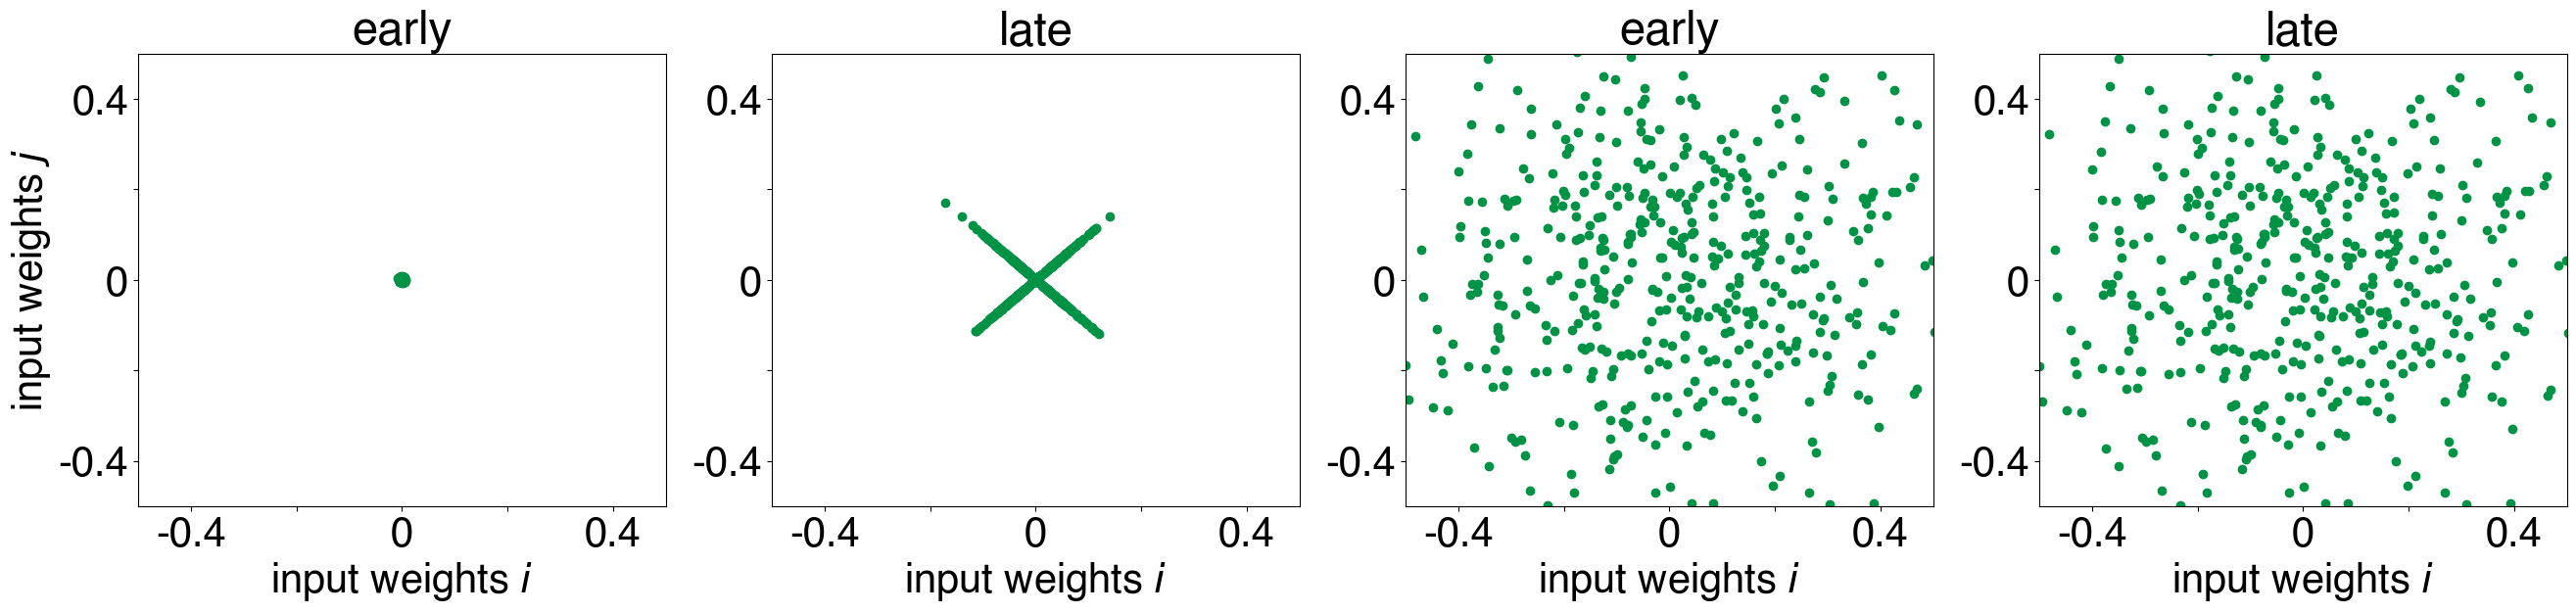

In [8]:
model_titles = ['early', 'late']

fig, axes = plt.subplots(1, 4)
fig.set_size_inches(32, 6)

for w_i, weight in enumerate(w1_inits):
    init_model = init_models[w_i]
    trained_model = trained_models[w_i]
    
    for m_i, model in enumerate([init_model, trained_model]):
        fig_i = w_i*2 + m_i
        axis = axes[fig_i]
        
        for p_i, (name, param) in enumerate(model.named_parameters()):
            if name == 'in_hid.weight':
                in_hid = param.detach().numpy()
                axis = plot_hidden_in(in_hid, axis)
                if fig_i != 0:
                    axis.set_ylabel(None)
                axis.set_title(f'{model_titles[m_i]}', fontsize=34)

# fig.savefig("rich_lazy_learning_hidden_in.svg")

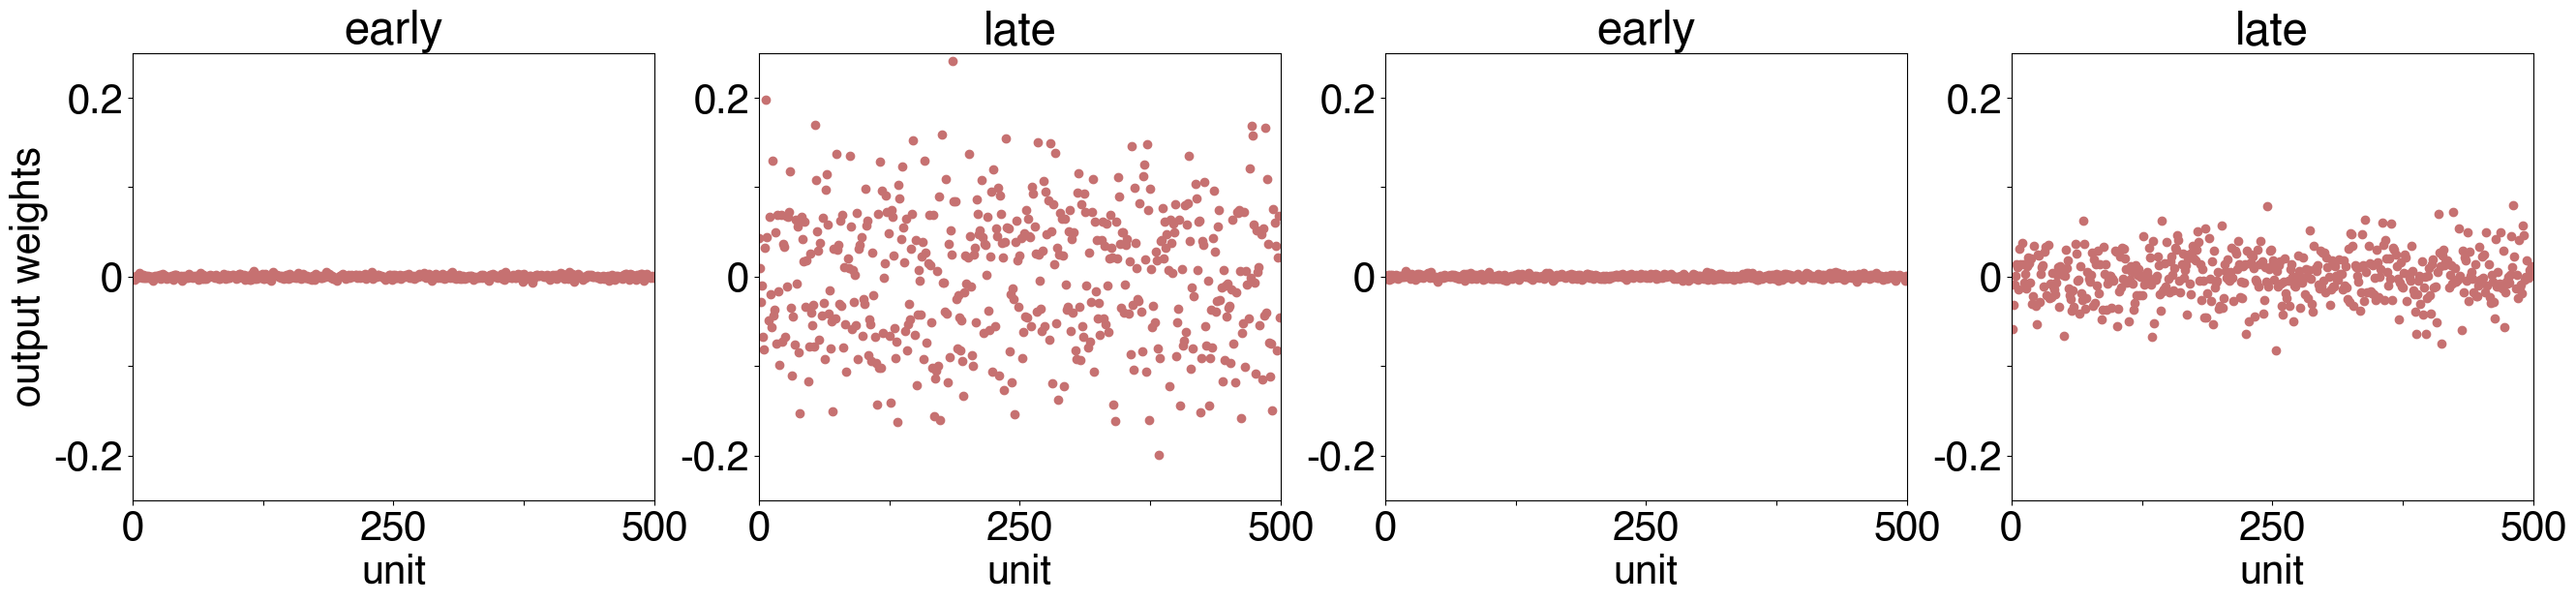

In [19]:
model_titles = ['early', 'late']

fig, axes = plt.subplots(1, 4)
fig.set_size_inches(32, 6)

for w_i, weight in enumerate(w1_inits):
    init_model = init_models[w_i]
    trained_model = trained_models[w_i]
    
    for m_i, model in enumerate([init_model, trained_model]):
        fig_i = w_i*2 + m_i
        axis = axes[fig_i]
        
        for p_i, (name, param) in enumerate(model.named_parameters()):
            if name == 'hid_out.weight':
                hid_out = param.detach().numpy()
                axis = plot_hidden_out(hid_out, axis)
                if fig_i != 0:
                    axis.set_ylabel(None)
                axis.set_title(f'{model_titles[m_i]}', fontsize=34)

# fig.savefig("rich_lazy_learning_hidden_out.svg")

## Robustnesss vs. Learning speed (stability vs. adaptability)

In [10]:
noise_ranges = np.arange(0.1, 2.1, 0.1)
n_runs = 1000
noise_errors = np.zeros((len(trained_models), noise_ranges.shape[0], n_runs))

criterion = nn.MSELoss()
for m_i, model in enumerate(trained_models):
    for n_i, noise_lev in enumerate(noise_ranges):
        for r_i in range(n_runs):
            noisy_X, noisy_y = create_xor_dataset(x1, x2, y_np, n_repeats=1, noise_lev=noise_lev)
            noisy_y_pred = model(noisy_X)[0].detach()
            noisy_loss = criterion(noisy_y_pred, noisy_y).numpy()
            noise_errors[m_i, n_i, r_i] = noisy_loss

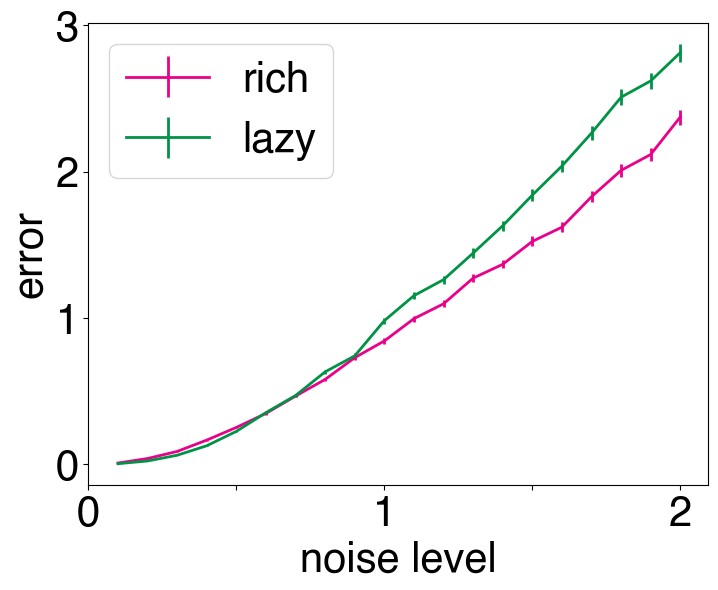

In [31]:
model_titles = ['rich', 'lazy']

fig, axis = plt.subplots()
fig.set_size_inches(8, 6)

mean_errors = np.mean(noise_errors, 2)
std_errors = np.std(noise_errors, 2) / np.sqrt(n_runs)

for m_i, model in enumerate(trained_models):
    axis.errorbar(noise_ranges, mean_errors[m_i], yerr=std_errors[m_i],
                  color=COLORS[model_titles[m_i]], linewidth=2, label=model_titles[m_i])
axis.set_xlabel('noise level')
axis.set_ylabel('error')
axis.set_xticks([0, 0.5, 1, 1.5, 2])
axis.set_xticklabels([0, None, 1, None, 2])
axis.set_yticks([0, 1, 2, 3])
axis.legend()

# fig.savefig("rich_lazy_noise_robust.svg")